In [78]:
!pip uninstall opencv-python opencv-contrib-python opencv-contrib-python-headless -y

Found existing installation: opencv-contrib-python 4.9.0.80
Uninstalling opencv-contrib-python-4.9.0.80:
  Successfully uninstalled opencv-contrib-python-4.9.0.80


In [79]:
!pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (68.3 MB)


In [80]:
!pip install imutils

In [81]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

In [82]:
import cv2
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

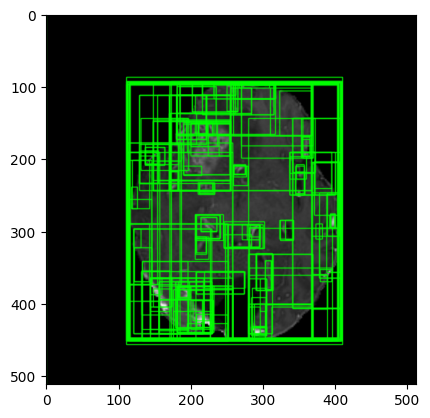

In [83]:
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/train/00095_170.jpg"
im = cv2.imread(path)
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()

# num_regions = 2000
# rects = rects[:num_regions]

imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [84]:
len(rects)

250

In [85]:
def get_iou(bb1, bb2):
#     print(bb1)
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [86]:
train_images=[]
train_labels=[]
train_bboxes=[]
annot = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/train"
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/train"
for e,i in enumerate(os.listdir(annot)):
    try:
        gtvalues=[]
        filename = i.split(".")[0]+".jpg"
        image = cv2.imread(os.path.join(path,filename))
        h, w, _ = image.shape
        df = pd.read_csv(os.path.join(annot,i))
        for row in df.iterrows():
            label = int(float(row[1].iloc[0].split(" ")[0]))
            x2 = int(float(row[1].iloc[0].split(" ")[1]) * w)
            y2 = int(float(row[1].iloc[0].split(" ")[2]) * h)
            x1 = int(float(row[1].iloc[0].split(" ")[3]) * w)
            y1 = int(float(row[1].iloc[0].split(" ")[4]) * h)
            gtvalues.append({"label":label, "x1":x1,"x2":x2,"y1":y1,"y2":y2})
            
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
#         ss.switchToSelectiveSearchQuality()
        rects = ss.process()
        imout = image.copy()
        
        positive_count = 0
        negative_count = 0
        
        flag = 0
        fflag = 0
        bflag = 0
        for e,rect in enumerate(rects):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:
                    x,y,w,h = rect
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if positive_count < 30:
                        if iou > 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(1)
                            positive_count += 1
#                             train_bboxes.append([x, y, x+w, y+h])
                            train_bboxes.append([x, y, w, h])
                    else :
                        fflag =1
                    if negative_count <30:
                        if iou < 0.3:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                            train_images.append(resized)
                            train_labels.append(0)
                            negative_count += 1
                            train_bboxes.append([x, y, w, h])
                    else :
                        bflag = 1
                if fflag == 1 and bflag == 1:
                    print("inside")
                    flag = 1
    except Exception as e:
        print("error in "+filename)
        continue

inside


In [87]:
# Chuyển đổi train_images thành mảng numpy
train_images_array = np.array(train_images)

# Chuyển đổi train_labels thành mảng numpy
train_labels_array = np.array(train_labels)

# Chuyển đổi train_bboxes thành mảng numpy
# Đầu tiên, xác định số lượng hộp giới hạn tối đa trong một mẫu
max_num_bboxes = max(len(bboxes) for bboxes in train_bboxes)
# Tạo một mảng numpy để chứa các hộp giới hạn, sử dụng giá trị -1 để đánh dấu các hộp giới hạn không sử dụng
train_bboxes_array = np.full((len(train_bboxes), max_num_bboxes), -1, dtype=np.float32)
# Điền các hộp giới hạn vào mảng
for i, bboxes in enumerate(train_bboxes):
    for j, bbox in enumerate(bboxes):
        train_bboxes_array[i, j] = bbox

# Kiểm tra kích thước của các mảng
print("Kích thước của train_images_array:", train_images_array.shape)
print("Kích thước của train_labels_array:", train_labels_array.shape)
print("Kích thước của train_bboxes_array:", train_bboxes_array.shape)


Kích thước của train_images_array: (471, 224, 224, 3)
Kích thước của train_labels_array: (471,)
Kích thước của train_bboxes_array: (471, 4)


In [88]:
train_bboxes_array

array([[ 41.,  54., 110.,  48.],
       [ 85., 154.,  24.,  40.],
       [  0.,   0., 192., 256.],
       ...,
       [ 23.,  70.,  43., 135.],
       [ 23.,  70.,  51., 145.],
       [ 23., 124.,  51.,  91.]], dtype=float32)

In [89]:
train_labels_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [90]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
tf.config.set_soft_device_placement(True)

In [91]:
# vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
for layer in vggmodel.layers[:-2]:
    layer.trainable = False
vggmodel.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 20,878,312 (79.64 MB)

 Non-trainable params: 117,479,232 (448.15 MB)

In [92]:
x = vggmodel.get_layer('flatten')
last_output =  x.output

In [93]:
x = Dense(1, activation='sigmoid', name='predictions')(last_output)
model = Model(inputs=vggmodel.input, outputs=x)

In [94]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [95]:
x = model.get_layer('flatten').output
model_extractfeatures = Model(inputs=model.input, outputs=x)

In [96]:
len(train_images)

471

In [97]:
# extract features
train_features = model_extractfeatures.predict(train_images_array)
# val_features = model_extractfeatures.predict(val_images_svm)
train_features.shape

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


(471, 25088)

In [98]:
train_features.shape

(471, 25088)

In [99]:
reg_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(25088,)),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(4, activation="sigmoid")
])

In [100]:
from keras.optimizers import Adam
# opt = Adam(learning_rate=0.0001)
opt = Adam()

In [101]:
reg_model.compile(loss = "mse", optimizer = opt)
reg_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,605,956 (6.13 MB)

 Trainable params: 1,605,956 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
reg_model.fit(train_features, np.array(train_bboxes), batch_size = 64, epochs= 10)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 10978.4443
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11156.9473 
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10872.7324 
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10595.8984
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10867.8369 
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10865.1436 
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11209.2539 
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10875.8877 
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10943.0674 
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10782.5820 


In [103]:
box_offset = reg_model.predict(train_features)
box_offset.shape

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


(471, 4)

In [104]:
pred_boxes = box_offset + train_bboxes
pred_boxes.shape

(471, 4)

In [105]:
pred_boxes

array([[ 42.,  55., 111.,  49.],
       [ 86., 155.,  25.,  41.],
       [  1.,   1., 193., 257.],
       ...,
       [ 24.,  71.,  44., 136.],
       [ 24.,  71.,  52., 146.],
       [ 24., 125.,  52.,  92.]])

In [106]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
import joblib

In [107]:
clf = SVC(probability=True)
clf.fit(train_features, train_labels_array)
# save model 
joblib.dump(clf, './model_svm.pkl')

['./model_svm.pkl']

Regression

In [108]:
predictions = clf.predict(train_features)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [109]:
predictions_proba = clf.predict_proba(train_features)
predictions_proba[:3]

array([[0.97700665, 0.02299335],
       [0.9918435 , 0.0081565 ],
       [0.97699527, 0.02300473]])

In [110]:
score_predictions = []
# bbox_predictions = []
for i in range(len(predictions_proba)):
    if predictions_proba[i][1] > 0.99:
        x, y, w, h = train_bboxes[i]
        # img = cv2.rectangle(img, (x, y), (w, h), (0, 255, 0), 3)
        score_predictions.append(predictions_proba[i][1])
#         bbox_predictions.append([x, y, w, h])

In [111]:
score_predictions

[0.9919524466065055,
 0.9923145954421597,
 0.9935777683605693,
 0.9933035497718622,
 0.9910530680325811,
 0.9924814418273503,
 0.9918666643497138,
 0.9929386248604636,
 0.9929398968534436,
 0.9951667188412439,
 0.9929301548785976,
 0.9935278218555034,
 0.9929296244451392,
 0.9929215752903846,
 0.9949259912243655,
 0.9920630064288777,
 0.9916333838013152,
 0.992924235781382,
 0.9929446517464204,
 0.9949031244665002,
 0.993798838928313,
 0.9949322128811,
 0.9946708745445226,
 0.9944247656995223,
 0.9947139313413327,
 0.9929475998076861,
 0.9929893750037294,
 0.9938791447570291,
 0.9940462758463685,
 0.9929340020135619,
 0.9941447542368004,
 0.9944598982055365,
 0.9942218176433513,
 0.994436438308744,
 0.9929450846578503,
 0.9929289295087821,
 0.9947504813711554,
 0.9940043505171069,
 0.9947176048965058,
 0.9960902834398986,
 0.9946074613466607,
 0.9945601456420302,
 0.9929341216512803,
 0.9929182498683008,
 0.9929356312480878,
 0.9929351333358701]

In [112]:
bbox_predictions = np.array(pred_boxes)
bbox_predictions

array([[ 42.,  55., 111.,  49.],
       [ 86., 155.,  25.,  41.],
       [  1.,   1., 193., 257.],
       ...,
       [ 24.,  71.,  44., 136.],
       [ 24.,  71.,  52., 146.],
       [ 24., 125.,  52.,  92.]])

In [113]:
# from imutils.object_detection import non_max_suppression
# pick = non_max_suppression(bbox_predictions, probs=score_predictions, overlapThresh=0.3)
# pick

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

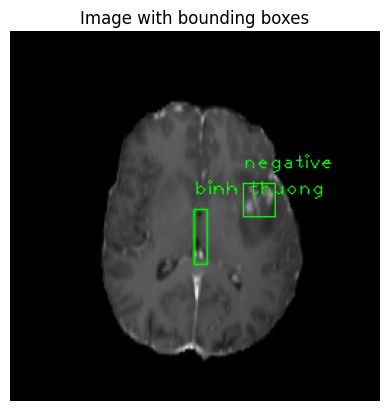

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

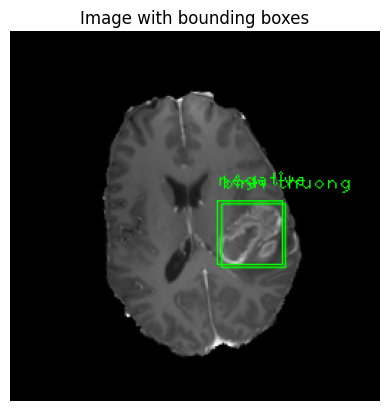

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

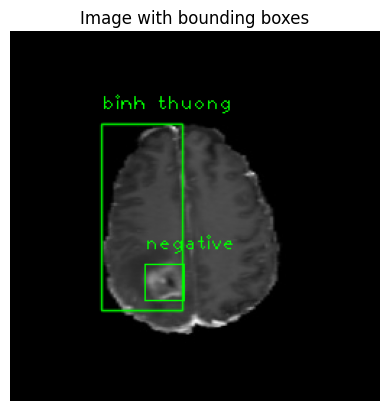

In [118]:
z = 0
path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test"
label_dir = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/test"
img_path = os.listdir(path)[:3]

for e, i in enumerate(img_path):
    img = cv2.imread(os.path.join(path, i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = img.copy()
    
    # Đọc nhãn từ tệp nhãn
    with open(os.path.join(label_dir, i.split('.')[0] + '.txt'), 'r') as f:
        labels = f.readline().split(' ')
    
    # Vẽ bounding box cho khu vực thực
    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])
    
    if tumor_class == 1:
        color = (255, 0, 0)  # Màu đỏ
        label = 'positive'
    else:
        color = (0, 255, 0)  # Màu xanh lá cây
        label = 'negative'
    
    cv2.rectangle(imout, (x_pt1, y_pt1), (x_pt2, y_pt2), color, 1)
    cv2.putText(imout, label, (x_pt1, y_pt1-10), cv2.FONT_HERSHEY_PLAIN, 0.9, color, 1)
    
    classes = []
    scores = []
    boxes = []
    
    for e, result in enumerate(ssresults):
        if e < 2000:
            x, y, w, h = result
            timage = imout[y:y+h, x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            
            feat = model_extractfeatures.predict(img)
            offset= reg_model.predict(feat)
            out = clf.predict_proba(feat)
            
            if out[0][0] > 0.8:
                boxes.append(result + offset.squeeze(0))
                classes.append(1)
                scores.append(out.max())
            #                 print(np.array(boxes).shape)
            else:
                classes.append(0)
            if out[0][1] > 0.95:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)


    selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=1, iou_threshold=0.5)
    selected_boxes = tf.gather(boxes, selected_indices)
    
    for i, box in enumerate(selected_boxes):
        x, y, w, h = box[:4]
        x = int(x)
        y = int(y)
        w = int(w)
        h = int(h)
        
        if classes[i] == 1:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
            cv2.putText(imout, 'binh thuong', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
        else:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(imout, 'khoi u', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)

    plt.figure()
    plt.imshow(imout)
    plt.title('Image with bounding boxes')
    plt.axis('off')
    plt.show()


In [115]:
# import os

# # Khởi tạo đối tượng selective search
# ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# z = 0
# path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test"
# label_dir = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/test"
# img_path = os.listdir(path)[:3]

# for e, i in enumerate(img_path):
#     img = cv2.imread(os.path.join(path, i))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     # Thiết lập ảnh cơ sở cho selective search
#     ss.setBaseImage(img)
#     ss.switchToSelectiveSearchQuality()  # Sử dụng chất lượng cao
    
#     # Thực hiện selective search và lấy kết quả
#     ssresults = ss.process()
#     imout = img.copy()
    
#     # Đọc nhãn từ tệp nhãn
#     with open(os.path.join(label_dir, i.split('.')[0] + '.txt'), 'r') as f:
#         labels = f.readline().split(' ')
    
#     # Vẽ bounding box cho khu vực thực
#     tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
#     x_pt1 = int(x * img.shape[1])
#     y_pt1 = int(y * img.shape[0])
#     w = int(w * img.shape[1])
#     h = int(h * img.shape[0])
#     x_pt2 = x_pt1 + w
#     y_pt2 = y_pt1 + h
    
#     if tumor_class == 1:
#         color = (255, 0, 0)  # Màu đỏ
#         label = 'positive'
#     else:
#         color = (0, 255, 0)  # Màu xanh lá cây
#         label = 'negative'
    
#     cv2.rectangle(imout, (x_pt1, y_pt1), (x_pt2, y_pt2), color, 1)
#     cv2.putText(imout, label, (x_pt1, y_pt1-10), cv2.FONT_HERSHEY_PLAIN, 0.9, color, 1)
    
#     classes = []
#     scores = []
#     boxes = []
    
#     for e, result in enumerate(ssresults):
#         if e < 2000:
#             x, y, w, h = result
#             timage = imout[y:y+h, x:x+w]
#             resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
#             img = np.expand_dims(resized, axis=0)
            
#             feat = model_extractfeatures.predict(img)
#             offset= reg_model.predict(feat)
#             out = clf.predict_proba(feat)
            
#             if out[0][0] > 0.8:
#                 boxes.append([x, y, w, h] + offset.squeeze(0))  # Thêm offset vào bounding box
#                 classes.append(1)
#                 scores.append(out.max())
#             else:
#                 classes.append(0)
#             if out[0][1] > 0.95:
#                 cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)


#     # Chuyển các bounding box thành tensor
#     boxes_tensor = tf.convert_to_tensor(boxes, dtype=tf.float32)
    
#     # Thực hiện non-max suppression trên tensor boxes_tensor
#     selected_indices = tf.image.non_max_suppression(boxes_tensor, scores, max_output_size=1, iou_threshold=0.5)
#     selected_boxes = tf.gather(boxes_tensor, selected_indices)
    
#     # Vẽ bounding box đã chọn lọc
#     for i, box in enumerate(selected_boxes):
#         x, y, w, h, _ = box  # Offset đã được thêm vào trong boxes
#         x = int(x)
#         y = int(y)
#         w = int(w)
#         h = int(h)
        
#         if classes[i] == 1:
#             cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
#             cv2.putText(imout, 'binh thuong', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
#         else:
#             cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
#             cv2.putText(imout, 'khoi u', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)

#     plt.figure()
#     plt.imshow(imout)
#     plt.title('Image with bounding boxes')
#     plt.axis('off')
#     plt.show()


In [116]:
# z=0
# path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test"
# img_path = os.listdir(path)[:2]
# # model_path = "/kaggle/working/ieeercnn_vgg16_1.keras"
# # model = keras.saving.load_model(model_path, custom_objects=None, compile=True, safe_mode=True)
# for e,i in enumerate(img_path):
#     classes = []
#     scores = []
#     boxes = []
#     z += 1
#     img = cv2.imread(os.path.join(path,i))
    
#     ss.setBaseImage(img)
#     ss.switchToSelectiveSearchFast()
#     ssresults = ss.process()
#     imout = img.copy()
    
#     for e,result in enumerate(ssresults):
#         if e < 2000:
#             x,y,w,h = result
#             timage = imout[y:y+h,x:x+w]
#             resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
#             img = np.expand_dims(resized, axis=0)
#             feat = model_extractfeatures.predict(img)

#             offset = reg_model.predict(feat)

#             out = clf.predict_proba(feat)

#             if out[0][0] > 0.8:
#                 boxes.append(result + offset.squeeze(0))
#                 classes.append(1)
#                 scores.append(out.max())
# #                 print(np.array(boxes).shape)
# #             else:
# #                 classes.append(0)
# #             if out[0][1] > 0.95:
# #                 cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

#     selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=1, iou_threshold=0.5)
#     selected_boxes = tf.gather(boxes, selected_indices)
#     for i, box in enumerate(selected_boxes):
#         x,y,w,h = box[:4]
#         x = int(x)
#         y = int(y)
#         w = int(w)
#         h = int(h)

#         if classes[i] == 1:
#             cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
#             cv2.putText(imout, 'khoi u', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
#         else:
#             cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 0, 0), 1, cv2.LINE_AA)
#             cv2.putText(imout, 'bth', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
            
#     plt.figure()
#     plt.imshow(imout)

# # img_test = img.copy()
# # for (startX, startY, endX, endY) in pick:
# #     img_test = cv2.rectangle(img_test, (startX, startY), (endX, endY), (0, 255, 0), 3)
# # plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

In [117]:
# import os

# z = 0
# path = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test"
# label_dir = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/labels/test"
# img_path = os.listdir(path)[:5]

# for e, i in enumerate(img_path):
#     img = cv2.imread(os.path.join(path, i))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     ss.setBaseImage(img)
#     ss.switchToSelectiveSearchFast()
#     ssresults = ss.process()
#     imout = img.copy()
    
#     # Đọc nhãn từ tệp nhãn
#     with open(os.path.join(label_dir, i.split('.')[0] + '.txt'), 'r') as f:
#         labels = f.readlines()
    
#     # Vẽ bounding box cho khu vực thực từ tệp nhãn
#     for label in labels:
#         values = label.split()[1:]
#         if len(values) == 5:
#             tumor_class, x, y, w, h = map(float, values)
#             x_pt1 = int((x - w/2) * img.shape[1])
#             y_pt1 = int((y - h/2) * img.shape[0])
#             x_pt2 = int((x + w/2) * img.shape[1])
#             y_pt2 = int((y + h/2) * img.shape[0])

#             if tumor_class == 1:
#                 color = (255, 0, 0)  # Màu đỏ
#                 label_text = 'positive'
#             else:
#                 color = (0, 255, 0)  # Màu xanh lá cây
#                 label_text = 'negative'
            
#             cv2.rectangle(imout, (x_pt1, y_pt1), (x_pt2, y_pt2), color, 1)
#             cv2.putText(imout, label_text, (x_pt1, y_pt1-10), cv2.FONT_HERSHEY_PLAIN, 0.9, color, 1)
    
#     # Vẽ bounding box cho khu vực được dự đoán từ Selective Search và mô hình SVM
#     classes = []
#     scores = []
#     boxes = []
    
#     for e, result in enumerate(ssresults):
#         if e < 2000:
#             x, y, w, h = result
#             timage = imout[y:y+h, x:x+w]
#             resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
#             img = np.expand_dims(resized, axis=0)
#             feat = model_extractfeatures.predict(img)
#             out = clf.predict_proba(feat)
            
#             if out[0][0] > 0.8:
#                 boxes.append(result)
#                 classes.append(1)
#                 scores.append(out.max())

#     selected_indices = tf.image.non_max_suppression(boxes, scores, max_output_size=1, iou_threshold=0.5)
#     selected_boxes = tf.gather(boxes, selected_indices)
    
#     for i, box in enumerate(selected_boxes):
#         x, y, w, h = box[:4]
#         x = int(x)
#         y = int(y)
#         w = int(w)
#         h = int(h)
        
#         if classes[i] == 1:
#             cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
#             cv2.putText(imout, 'khoi u', (x, y-10), cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)

#     plt.figure()
#     plt.imshow(imout)
#     plt.title('Image with bounding boxes')
#     plt.axis('off')
#     plt.show
